In [1]:
import tensorflow
import matplotlib.pyplot as plt     #grafik gösterimleri için

transfer_learning_model = tensorflow.keras.applications.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3)
                  )

#transfer_learning_model.summary()

In [3]:
transfer_learning_model.trainable = True
set_trainable = False
for layer in transfer_learning_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

#oluşturduğumuz modelin ardışık olduğunu belirliyoruz. Sequential
#veriler soldan sağa doğru akıyor.
model = tensorflow.keras.models.Sequential()        


#Burda vgg16 mimarisindeki convolüsyon ve pooling katmanları ekleniyor.
#aynı zamanda imagenet ağırlıkları da alınıyor.
model.add(transfer_learning_model)
model.add(tensorflow.keras.layers.Flatten())

model.summary()


#dense katmanı, içerisinde bir işlem yapmadan, sadece verileri verilern aktivasyon fonksiyonuna sokuyor.
#bu katmanda convolüsyon yada pooling işlemleri yok.
model.add(tensorflow.keras.layers.Dense(256,activation='relu'))

#softmax çıktılarımızı 0-1 arasına sıkıştırıyor. % üzerinden tahmin yapmak için gerekli.
model.add(tensorflow.keras.layers.Dense(3,activation='softmax'))

#model.summary()


model.compile(loss='binary_crossentropy',   #hatasını hangi fonksiyonu kullanarak ölçsün?
              #optimizer = tensorflow.keras.optimizers.Adam(learning_rate= 0.001,), #
              optimizer=tensorflow.keras.optimizers.RMSprop(lr=1e-5),  #modelim kendisini nasıl geliştirsin, neye göre iyileştirsin.
                                                                        #lr = learning rate -> öğrenme katsayısı
              metrics=['acc'])  #accuracy göre performansı değerlendiriyoruz.

#model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
Total params: 14,714,688
Trainable params: 7,079,424
Non-trainable params: 7,635,264
_________________________________________________________________


c:\Users\cakir\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [19]:
train_path = r'C:\MyProject\397199_397209\Data\ThreeClassDataBase\Train'
validation_path = r'C:\MyProject\397199_397209\Data\ThreeClassDataBase\Validation'
test_path = r'C:\MyProject\397199_397209\Data\ThreeClassDataBase\Test'

#data augmantation, resim çoğaltma teknikleri
train_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255,           # piksel değerleri 0-255'den 0-1 arasına getiriliyor.
      rotation_range=40,        #random 0-40 arasında döndürüyo
      width_shift_range=0.2,    #kaydırma işlemleri
      height_shift_range=0.2,   #kaydırma işlemleri
      shear_range=0.2,          #kırpma işlemleri
      zoom_range=0.2,           #yakınlaştırma
      horizontal_flip = False,  #burası önemli, aynalama denebilir.
      #brightness_range = [0.3, 1.0],
      fill_mode='nearest'       #kaydırma işlemlerinde boş pixel doldurma
      )

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=16,  #aynı anda kaç adet verinin işleneceğidir. Aynı anda 16 verinin hatası hesaplanır. veriler 16'şar 16'şar eğitilir.
                        #düşük olması demek, fazla optimizasyon hesaplaması anlamına gelir. Eğitim süresi daha uzun olur.
        )

validation_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255
        )

validation_generator = validation_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=16,
        )

Found 1242 images belonging to 3 classes.
Found 114 images belonging to 3 classes.


In [20]:
class MyThresholdCallback(tensorflow.keras.callbacks.Callback):
    def __init__(self, acc_limit,val_limit):
        super(MyThresholdCallback, self).__init__()
        self.acc_limit = acc_limit
        self.val_limit = val_limit
    def on_epoch_end(self, epoch, logs=None): 
        acc = logs["acc"]
        val_acc = logs["val_acc"]
        if val_acc >= self.val_limit :
            if acc >= self.acc_limit :
                self.model.stop_training = True

callbacks = MyThresholdCallback(acc_limit=0.7, val_limit=1)


history = model.fit( #eğitim takibi
      train_generator,
      steps_per_epoch=15, #
      epochs=5,
      validation_data=validation_generator,
      validation_steps=1,
      callbacks=[callbacks]
      )

Epoch 1/5
15/15 [==============================] - 31s 2s/step - loss: 0.6757 - acc: 0.3208 - val_loss: 0.6682 - val_acc: 0.2500
Epoch 2/5
15/15 [==============================] - 29s 2s/step - loss: 0.6324 - acc: 0.4083 - val_loss: 0.6271 - val_acc: 0.4375
Epoch 3/5
15/15 [==============================] - 33s 2s/step - loss: 0.6381 - acc: 0.3750 - val_loss: 0.6244 - val_acc: 0.3125
Epoch 4/5
15/15 [==============================] - 33s 2s/step - loss: 0.6311 - acc: 0.3833 - val_loss: 0.5933 - val_acc: 0.5625
Epoch 5/5
15/15 [==============================] - 33s 2s/step - loss: 0.6208 - acc: 0.3958 - val_loss: 0.5775 - val_acc: 0.5625


In [22]:
model.save(r'C:\MyProject\397199_397209\Models\BunuSil_model.h5')

test_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255
        )

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=16,
        )


Found 291 images belonging to 3 classes.


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


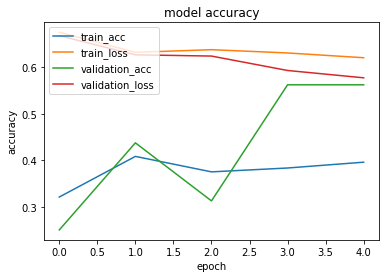

C:\Users\cakir\AppData\Local\Temp\ipykernel_7572\100370763.py:14: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)


test acc: 0.5326460599899292
lost acc: 0.5879021286964417


In [23]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'train_loss', 'validation_acc', 'validation_loss'], loc='upper left')
plt.show()

# Printing the test results.
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)
print('lost acc:', test_loss)
